In [1]:
# Import dependencies
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import tensorflow as tf
import psycopg2
import pycaret
from pycaret.classification import *

## Load Data

In [2]:
# Connect to postgres SQL database
conn = psycopg2.connect(database = 'postgres',
                        user =     'postgres',
                        password = 'Arya7328*',
                        host =     'bootcampproject.cs8v5ggqsbn0.us-west-1.rds.amazonaws.com',
                        port =     '5432')

# Create cursor object
cur = conn.cursor()

# Select all data from machine learning table
cur.execute('''
            SELECT *
            FROM ml_table;
            ''')

data = cur.fetchall()

# Create a dataframe
cols = []
for elt in cur.description:
    cols.append(elt[0])
        
health_df = pd.DataFrame (data=data,columns=cols)
pd.set_option('display.max_columns', None)
health_df.head(10)

,GENHLTH,MENTHLTH,PHYSHLTH,SEX,MARITAL_STATUS,EDUCATION,HOME_STATUS,VETERAN,EMPLOYMENT_SITUATION,INTERNET,DISABILITIES?,USEEQUIP,BLIND,ISSUES_DECISION_MAING,DIFFWALK,DIFFDRES,DIFFALON,HEALTHY_ADULTS,HEALTH_CVRAGE,DIABETE3,BLOOD_PRESSURE,_CHOLCHK,HIGH_CHOLESTEROL,CORONARY_DISEASE,ASTHMA_DISEASE,_ASTHMS1,HAS_ARTHRITIS,RACE,AGE_14LEVEL,BMI,4_BMI,CHILDREN2,EDUCATION_LEVEL,INCOME2,DRINKS_WEEK,HEAVY_DRINKER,FRUIT_CONSUMPTION,VEGGIE_COSUMPTION,PHYS_ACTIVITY_MINS,PHYS_CATEGORIES,PHYS_ACT_INDX,AER_STRGTH
0,3,88,88,2,2,6,1,2,3,1,1,2,1,1,2,2,2,1,2,3,1,2,1,2,1,3,2,1,7,2509,3,1,4,1,0.0,1,2,2,168.0,2,1,2
1,2,88,88,2,3,3,1,2,2,2,1,2,2,2,2,2,2,1,99,3,2,1,1,2,1,3,1,1,11,2652,3,1,1,4,0.0,1,1,1,330.0,1,1,2
2,2,3,88,2,3,5,1,2,7,2,2,2,2,2,2,2,2,1,99,3,2,1,2,2,1,3,2,1,11,2389,2,1,3,2,70.0,1,1,1,345.0,1,1,2
3,2,88,2,1,1,6,1,2,7,1,2,2,2,2,2,2,2,1,99,3,2,1,2,2,1,3,2,1,10,2522,3,1,4,5,0.0,1,1,1,300.0,2,1,2
4,3,88,88,2,3,4,1,2,5,1,1,2,2,2,1,2,2,1,99,3,2,1,2,2,2,1,1,1,11,2500,3,1,2,2,93.0,1,2,1,210.0,2,1,2
5,3,88,14,2,3,3,1,2,7,2,1,1,2,2,2,2,2,1,99,3,2,1,2,1,1,3,1,1,13,2579,3,1,1,99,0.0,1,1,1,90.0,3,2,4
6,3,88,88,1,1,6,1,1,7,1,2,2,2,2,2,2,2,1,99,1,1,1,1,2,1,3,1,1,13,2468,2,1,4,5,23.0,1,1,1,280.0,2,1,2
7,5,99,99,1,2,4,2,1,99,2,1,1,2,2,1,1,1,2,1,1,2,1,2,1,1,3,1,1,99,2848,3,1,2,2,0.0,1,1,1,60.0,3,2,4
8,4,30,28,2,1,6,1,2,8,1,1,2,2,1,2,2,1,2,1,3,1,1,2,2,1,3,1,1,4,3328,4,1,4,1,0.0,1,2,1,0.0,99,99,99
9,2,5,88,2,1,6,1,2,1,1,2,2,2,2,2,2,2,1,1,3,2,1,1,2,1,3,2,1,6,3328,4,1,4,5,93.0,1,2,2,180.0,2,1,1


## Check Preprocessing

In [3]:
# Check size and shape of dataframe
health_df.shape

(222168, 42)

In [4]:
# Check data types
health_df.dtypes

GENHLTH                    int64
MENTHLTH                   int64
PHYSHLTH                   int64
SEX                        int64
MARITAL_STATUS             int64
EDUCATION                  int64
HOME_STATUS                int64
VETERAN                    int64
EMPLOYMENT_SITUATION       int64
INTERNET                   int64
DISABILITIES?              int64
USEEQUIP                   int64
BLIND                      int64
ISSUES_DECISION_MAING      int64
DIFFWALK                   int64
DIFFDRES                   int64
DIFFALON                   int64
HEALTHY_ADULTS             int64
HEALTH_CVRAGE              int64
DIABETE3                   int64
BLOOD_PRESSURE             int64
_CHOLCHK                   int64
HIGH_CHOLESTEROL           int64
CORONARY_DISEASE           int64
ASTHMA_DISEASE             int64
_ASTHMS1                   int64
HAS_ARTHRITIS              int64
RACE                       int64
AGE_14LEVEL                int64
BMI                        int64
4_BMI     

In [5]:
# Double check for null values
health_df.isna().sum().sum()

0

## Feature Engineering

### For numerical, ordered data, change none code (88) to 0, change did not respond code (99) to median of the feature, and removed outliers in skewed distributions

In [6]:
# GENHLTH: values over 5 changed to median
for index, row in health_df.iterrows():
    if health_df.loc[index, 'GENHLTH'] > 5:
        health_df.loc[index, 'GENHLTH'] = health_df.GENHLTH.median()

In [9]:
# MENTHLTH: 88 changed to 0, 99 and over 30 changed to median
for index, row in health_df.iterrows():
    if health_df.loc[index, 'MENTHLTH'] == 88:
        health_df.loc[index, 'MENTHLTH'] = 0
    elif (health_df.loc[index, 'MENTHLTH'] == 99) or (health_df.loc[index,'MENTHLTH'] > 30):
        health_df.loc[index, 'MENTHLTH'] = health_df.MENTHLTH.median()

In [10]:
# PHYSHLTH: 88 changed to 0, 99 and over 30 changed to median
for index, row in health_df.iterrows():
    if health_df.loc[index, 'PHYSHLTH'] == 88:
        health_df.loc[index, 'PHYSHLTH'] = 0
    elif (health_df.loc[index, 'PHYSHLTH'] == 99) or (health_df.loc[index,'PHYSHLTH'] > 30):
        health_df.loc[index, 'PHYSHLTH'] = health_df.PHYSHLTH.median()

In [11]:
# AGE_14LEVEL: values over 13 changed to median
for index, row in health_df.iterrows():
    if health_df.loc[index, 'AGE_14LEVEL'] > 13:
        health_df.loc[index, 'AGE_14LEVEL'] = health_df.AGE_14LEVEL.median()

In [12]:
# For the following columns, values over 8 changed to median
change_cols = ['CHILDREN2', 'EDUCATION_LEVEL', 'INCOME2', 'PHYS_CATEGORIES']
for col in change_cols:
    for index, row in health_df.iterrows():
        if health_df.loc[index, col] > 8:
            health_df.loc[index, col] = health_df[col].median()

In [13]:
# BMI: Remove outliers
for index, row in health_df.iterrows():
    if health_df.loc[index, 'BMI'] > 6000:
        health_df.loc[index, 'BMI'] = health_df.BMI.median()

In [14]:
# PHYS_ACTIVITY_MINS: Remove outliers
for index, row in health_df.iterrows():
    if health_df.loc[index, 'PHYS_ACTIVITY_MINS'] > 5000:
        health_df.loc[index, 'PHYS_ACTIVITY_MINS'] = health_df.PHYS_ACTIVITY_MINS.median()

In [15]:
# DRINKS_WEEK: Remove outliers
for index, row in health_df.iterrows():
    if health_df.loc[index, 'DRINKS_WEEK'] > 1500:
        health_df.loc[index, 'DRINKS_WEEK'] = health_df.DRINKS_WEEK.median()

array([[<AxesSubplot:title={'center':'MENTHLTH'}>]], dtype=object)

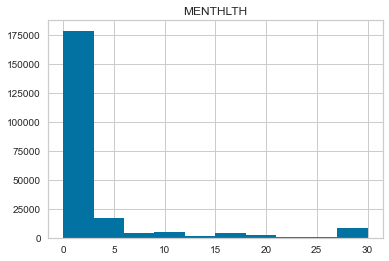

In [16]:
# Look at histogram of target (MENTHLTH) to decide bin ranges
health_df.hist(column='MENTHLTH')

In [17]:
# Create 2 bins for mental health. One at 0, one from 1-30
for index, row in health_df.iterrows():
    if health_df.loc[index,'MENTHLTH'] > 0:
        health_df.loc[index, 'MENTHLTH'] = 1

array([[<AxesSubplot:title={'center':'MENTHLTH'}>]], dtype=object)

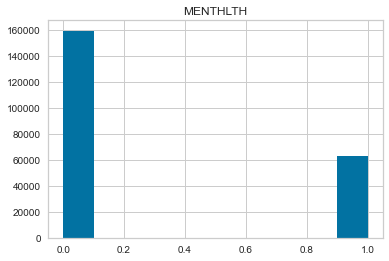

In [18]:
# Check target column bins
health_df.hist(column='MENTHLTH')

In [19]:
# Save cleaned health_df to csvs
health_df.to_csv("cleaned_health_df")

## Feature Selection

In [23]:
# PyCaret Setup
# "Normalize = True" scales the data based on z-score
# "transformation = True" changes the shape of the distribution to approximately normal
# "bin_numeric_features" creates bins for continuous categorical features based on sturges rule and K-means clusters
exp_clf101 = setup(data = health_df, target = 'MENTHLTH', session_id=123,
                   normalize = True,
                   transformation = True,
                   bin_numeric_features = ['PHYSHLTH', 'BMI', 'PHYS_ACTIVITY_MINS', 'DRINKS_WEEK'])

,Description,Value
0,Session id,123
1,Target,MENTHLTH
2,Target type,Binary
3,Original data shape,"(222168, 42)"
4,Transformed data shape,"(222168, 42)"
5,Transformed train set shape,"(155517, 42)"
6,Transformed test set shape,"(66651, 42)"
7,Numeric features,41
8,Preprocess,True
9,Imputation type,simple


In [24]:
# Create a random forest classifier
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7512,0.7119,0.3032,0.6242,0.4081,0.2738,0.3024
1,0.7489,0.7140,0.2948,0.6179,0.3991,0.2648,0.2938
2,0.7495,0.7108,0.3045,0.6158,0.4075,0.2711,0.2981
3,0.7468,0.7151,0.2943,0.6086,0.3968,0.2603,0.2878
4,0.7484,0.7174,0.3032,0.6116,0.4054,0.2682,0.2948
5,0.7512,0.7157,0.3055,0.6228,0.4099,0.2749,0.3029
6,0.7475,0.7119,0.2914,0.6131,0.3950,0.2601,0.2889
7,0.7502,0.7123,0.3091,0.6171,0.4119,0.2749,0.3014
8,0.7482,0.7152,0.3055,0.6098,0.4070,0.2690,0.2949


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

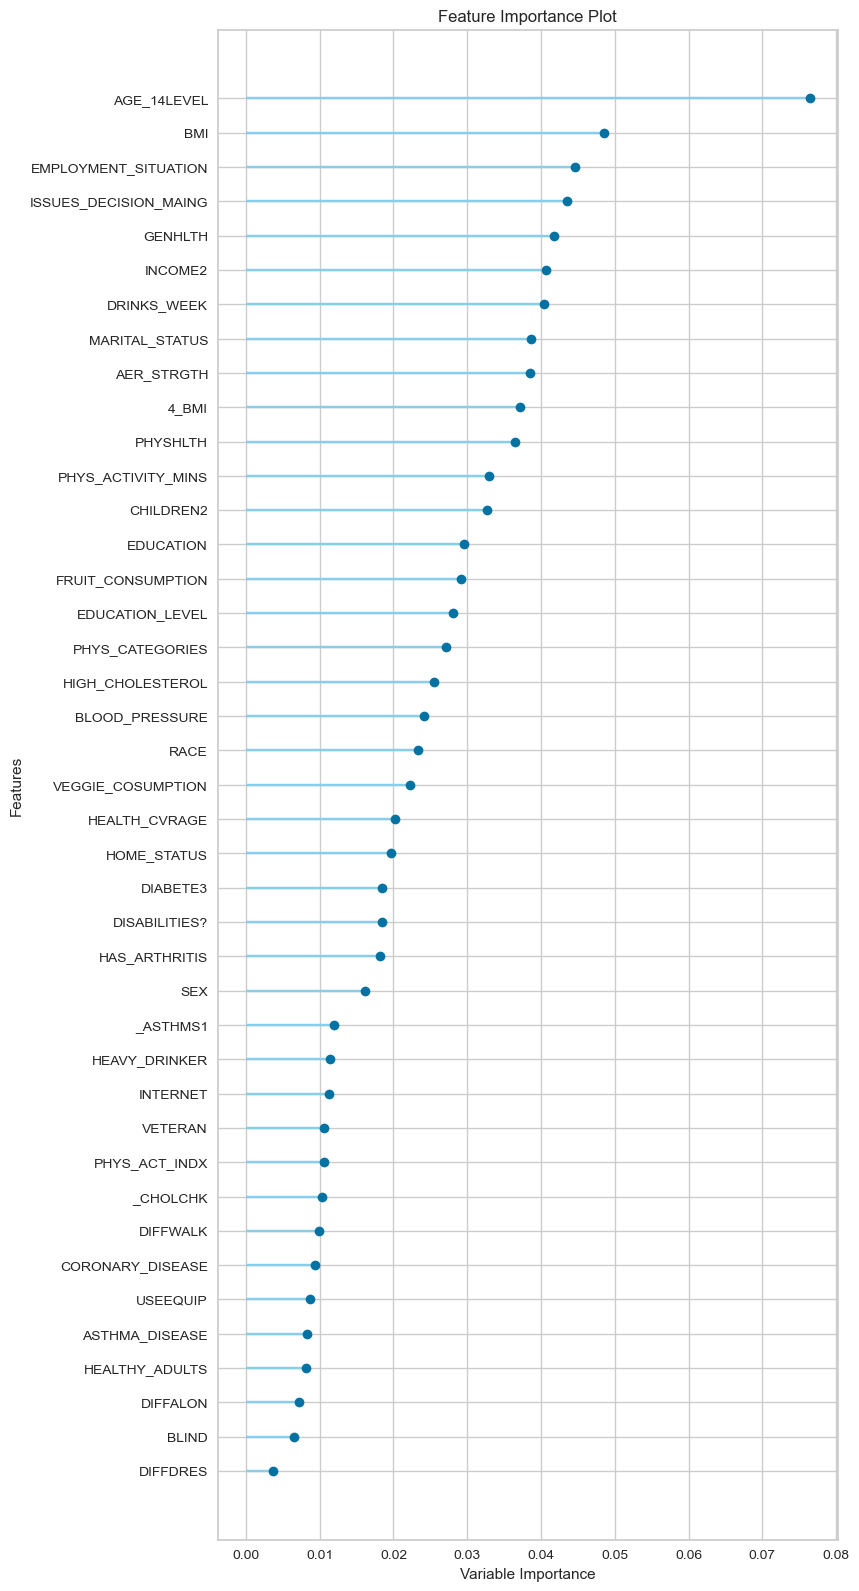

In [26]:
# Feature importance plot
plot_model(rf, plot='feature_all')

In [27]:
# Keep only 27 highest features (over 0.015 variable importance)
highest_features = ['MENTHLTH','AGE_14LEVEL','BMI','EMPLOYMENT_SITUATION','ISSUES_DECISION_MAING','GENHLTH','INCOME2', \
                    'DRINKS_WEEK','MARITAL_STATUS','AER_STRGTH','4_BMI','PHYSHLTH','PHYS_ACTIVITY_MINS','CHILDREN2', \
                    'EDUCATION','FRUIT_CONSUMPTION','EDUCATION_LEVEL','PHYS_CATEGORIES','HIGH_CHOLESTEROL', \
                    'BLOOD_PRESSURE','RACE','VEGGIE_COSUMPTION','HEALTH_CVRAGE','HOME_STATUS','DIABETE3','DISABILITIES?', \
                    'HAS_ARTHRITIS','SEX']

fs_health_df = health_df.filter(highest_features, axis=1)

## Split Data and Setup PyCaret

In [31]:
# Separate data into training and testing sets
data = fs_health_df.sample(frac=0.95, random_state=123).reset_index(drop=True)
data_unseen = fs_health_df.drop(data.index).reset_index(drop=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (211060, 28)
Unseen Data For Predictions: (11108, 28)


In [32]:
# PyCaret Setup
# "normalize = True" scales the data based on z-score
# "transformation = True" changes the shape of the distribution to approximately normal
# "bin_numeric_features" creates bins for continuous categorical features based on sturges rule and K-means clusters
exp_clf101 = setup(data = data, 
                   target = 'MENTHLTH',
                   session_id=123,
                   normalize = True,
                   transformation = True,
                   bin_numeric_features = ['PHYSHLTH', 'BMI', 'PHYS_ACTIVITY_MINS', 'DRINKS_WEEK'])

,Description,Value
0,Session id,123
1,Target,MENTHLTH
2,Target type,Binary
3,Original data shape,"(211060, 28)"
4,Transformed data shape,"(211060, 28)"
5,Transformed train set shape,"(147741, 28)"
6,Transformed test set shape,"(63319, 28)"
7,Numeric features,27
8,Preprocess,True
9,Imputation type,simple


## Compare Binary Classification Machine Learning Models

In [33]:
# Model training and selection (runtime ~ 35min)
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7576,0.7395,0.2665,0.6847,0.3836,0.2674,0.3137,8.8230
lightgbm,Light Gradient Boosting Machine,0.7575,0.7408,0.2897,0.6644,0.4035,0.2797,0.3177,1.4730
ada,Ada Boost Classifier,0.7567,0.7366,0.2821,0.6659,0.3963,0.2740,0.3137,2.7450
lr,Logistic Regression,0.7553,0.7312,0.2752,0.6634,0.3890,0.2674,0.3079,2.7980
ridge,Ridge Classifier,0.7552,0.0000,0.2515,0.6837,0.3677,0.2542,0.3032,0.1560
lda,Linear Discriminant Analysis,0.7551,0.7307,0.2839,0.6556,0.3961,0.2716,0.3090,0.5460
qda,Quadratic Discriminant Analysis,0.7461,0.7257,0.3448,0.5878,0.4346,0.2850,0.3018,0.4190
svm,SVM - Linear Kernel,0.7456,0.0000,0.1825,0.6915,0.2888,0.1935,0.2577,0.9000
rf,Random Forest Classifier,0.7446,0.7092,0.3035,0.5961,0.4022,0.2611,0.2851,9.6070
et,Extra Trees Classifier,0.7379,0.6985,0.3085,0.5683,0.3998,0.2506,0.2697,11.4680


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

In [34]:
# Best performing model (by accuracy)
print(best_model)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [35]:
# Create gradient boosting classifier model
gbc = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7561,0.7406,0.2719,0.6704,0.3869,0.2672,0.3096
1,0.7585,0.7422,0.2617,0.6946,0.3801,0.2665,0.3156
2,0.7603,0.7387,0.2717,0.6961,0.3908,0.2758,0.3232
3,0.7569,0.7347,0.2669,0.6797,0.3833,0.2662,0.3114
4,0.7592,0.7413,0.2712,0.6894,0.3893,0.2731,0.3193
5,0.7603,0.7461,0.2704,0.6973,0.3897,0.2750,0.3229
6,0.7542,0.7410,0.2628,0.6669,0.3770,0.2583,0.3019
7,0.7595,0.7368,0.2707,0.6924,0.3892,0.2736,0.3205
8,0.7552,0.7351,0.2578,0.6780,0.3735,0.2578,0.3044


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

## Tune Model and Analyze Performance

In [36]:
# Automatically tune model parameters using PyCaret (runtime ~ 25min)
tuned_gbc = tune_model(gbc)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7529,0.7338,0.3082,0.6297,0.4139,0.2799,0.3086
1,0.7563,0.7380,0.2980,0.6517,0.4090,0.2814,0.3156
2,0.7531,0.7294,0.2985,0.6361,0.4063,0.2753,0.3067
3,0.7564,0.7288,0.3093,0.6452,0.4181,0.2874,0.3185
4,0.7539,0.7329,0.3028,0.6371,0.4105,0.2791,0.3099
5,0.7523,0.7390,0.3066,0.6281,0.4120,0.2780,0.3067
6,0.7497,0.7314,0.2920,0.6236,0.3977,0.2650,0.2955
7,0.7525,0.7280,0.3056,0.6296,0.4115,0.2779,0.3070
8,0.7494,0.7270,0.2924,0.6218,0.3978,0.2646,0.2946


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


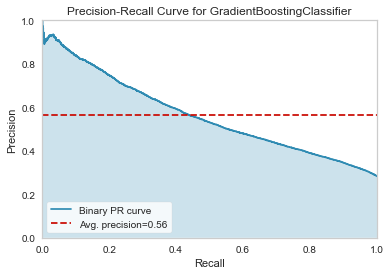

In [37]:
# Precision Recall Curve
plot_model(tuned_gbc, plot = 'pr')

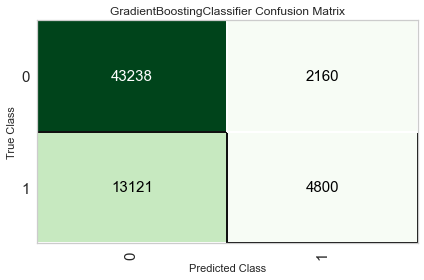

In [38]:
# Confusion Matrix
plot_model(tuned_gbc, plot = 'confusion_matrix')

In [39]:
# Predict using held-back test sample
predict_model(tuned_gbc);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.7587,0.7382,0.2678,0.6897,0.3858,0.2703,0.3172


In [40]:
# Save the model
save_model(tuned_gbc,'Final_GBC_Model_4Sep22')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=C:\Users\kylie\AppData\Local\Temp\joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['AGE_14LEVEL', 'BMI',
                                              'EMPLOYMENT_SITUATION',
                                              'ISSUES_DECISION_MAING', 'GENHLTH',
                                              'INCOME2', 'DRINKS_WEEK',
                                              'MARITAL_STATUS', 'AER_STRGTH',
                                              '4_BMI', 'PHYSHLTH',
                                              'PHYS_ACTIVITY_MINS', 'CHILDREN2',
                                              'EDUCATION', 'FRUIT_CONSU...
                                             criterion='friedman_mse', init=None,
                                             learning_rate=0.1, loss='deviance',
                                             max_depth=3, max_features=None,
 